In [ ]:
from torch import nn
from collections import OrderedDict
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torchvision
import random
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision import transforms
import progressbar as pb
import numpy as np

In [ ]:
SUM = lambda x,y : x+y

In [ ]:
def check_equity(property,a,b):
    pa = getattr(a,property)
    pb = getattr(b,property)
    assert  pa==pb, "Different {}: {}!={}".format(property,pa,pb)

    return pa

In [ ]:
def module_unwrap(mod:nn.Module,recursive=False):
    children = OrderedDict()
    try:
        for name, module in mod.named_children():
            if (recursive):
                recursive_call = module_unwrap(module,recursive=True)
                if (len(recursive_call)>0):
                    for k,v in recursive_call.items():
                        children[name+"_"+k] = v
                else:
                    children[name] = module
            else:
                children[name] = module
    except AttributeError:
        pass

    return children

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn1 = nn.GroupNorm(16, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn2 = nn.GroupNorm(16, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

In [ ]:
class Classifier(nn.Module):

    def __init__(self,num_classes=1):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):

        return self.classifier(x)

In [ ]:
class VGG16(nn.Module):

  def __init__(self, input_size, batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    # x = self.avgpool(x)
    x = torch.flatten(x,1)

    return x

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, loss_a, loss_b, loss_combo, _lambda=1.0):
        super().__init__()
        self.loss_a = loss_a
        self.loss_b = loss_b
        self.loss_combo = loss_combo

        self.register_buffer('_lambda',torch.tensor(float(_lambda),dtype=torch.float32))


    def forward(self,y_hat,y):

        return self.loss_a(y_hat[0],y[0]) + self.loss_b(y_hat[1],y[1]) + self._lambda * self.loss_combo(y_hat[2],torch.cat(y,0))

----------------------------------------------------------------------

In [ ]:
DO='TRAIN'

In [ ]:
random.seed(47)

In [ ]:
combo_fn = SUM

In [ ]:
lambda_reg = 1

In [ ]:
def test(net,classifier, loader):

      net.to(dev)
      classifier.to(dev)

      net.eval()

      sum_accuracy = 0

      # Process each batch
      for j, (input, labels) in enumerate(loader):

        input = input.to(dev)
        labels = labels.float().to(dev)

        features = net(input)

        pred = torch.squeeze(classifier(features))

        # https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
        pred_labels = (pred >= 0.0).long()  # Binarize predictions to 0 and 1

        batch_accuracy = (pred_labels == labels).sum().item() / len(labels)

        # Update accuracy
        sum_accuracy += batch_accuracy

      epoch_accuracy = sum_accuracy / len(loader)
      
      return epoch_accuracy

      #print(f"Accuracy: {epoch_accuracy:0.5}")

In [ ]:
def train(nets, loaders, optimizer, criterion, epochs=20, dev=None, save_param=False, model_name="valerio"):
    # try:
      nets = [n.to(dev) for n in nets]

      model_a = module_unwrap(nets[0], True)
      model_b = module_unwrap(nets[1], True)
      model_c = module_unwrap(nets[2], True)

      reg_loss = nn.MSELoss()

      criterion.to(dev)
      reg_loss.to(dev)

      # Initialize history
      history_loss = {"train": [], "val": [], "test": []}
      history_accuracy = {"train": [], "val": [], "test": []}
      history_test = []
      # Store the best val accuracy
      best_val_accuracy = 0

      # Process each epoch
      for epoch in range(epochs):
        # Initialize epoch variables
        sum_loss = {"train": 0, "val": 0, "test": 0}
        sum_accuracy = {"train": [0,0,0], "val": [0,0,0], "test": [0,0,0]}

        progbar = None
        # Process each split
        for split in ["train", "val", "test"]:
          if split == "train":
            for n in nets:
              n.train()
            widgets = [
              ' [', pb.Timer(), '] ',
              pb.Bar(),
              ' [', pb.ETA(), '] ', pb.Variable('ta','[Train Acc: {formatted_value}]')
            ]

            progbar = pb.ProgressBar(max_value=len(loaders[split][0]),widgets=widgets,redirect_stdout=True)

          else:
            for n in nets:
              n.eval()
          # Process each batch
          for j,((input_a, labels_a),(input_b, labels_b)) in enumerate(zip(loaders[split][0],loaders[split][1])):

            input_a = input_a.to(dev)
            input_b = input_b.to(dev)

            labels_a = labels_a.float().to(dev)
            labels_b = labels_b.float().to(dev)


            inputs = torch.cat([input_a,input_b],axis=0)
            labels = torch.cat([labels_a, labels_b])


            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            features_a = nets[0](input_a)
            features_b = nets[1](input_b)
            features_c = nets[2](inputs)

            pred_a = torch.squeeze(nets[3](features_a))
            pred_b = torch.squeeze(nets[3](features_b))
            pred_c = torch.squeeze(nets[3](features_c))

            loss = criterion(pred_a, labels_a) + criterion(pred_b, labels_b) + criterion(pred_c, labels)

            for n in model_a:
              layer_a = model_a[n]
              layer_b = model_b[n]
              layer_c = model_c[n]
              if (isinstance(layer_a,nn.Conv2d)):
                loss += lambda_reg * reg_loss(combo_fn(layer_a.weight,layer_b.weight),layer_c.weight)
                if (layer_a.bias is not None):
                  loss += lambda_reg * reg_loss(combo_fn(layer_a.bias, layer_b.bias), layer_c.bias)

            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
              # Compute gradients
              loss.backward()
              # Optimize
              optimizer.step()

            # Compute accuracy

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
            pred_labels_a = (pred_a >= 0.0).long()  # Binarize predictions to 0 and 1
            pred_labels_b = (pred_b >= 0.0).long()  # Binarize predictions to 0 and 1
            pred_labels_c = (pred_c >= 0.0).long()  # Binarize predictions to 0 and 1


            batch_accuracy_a = (pred_labels_a == labels_a).sum().item() / len(labels_a)
            batch_accuracy_b = (pred_labels_b == labels_b).sum().item() / len(labels_b)
            batch_accuracy_c = (pred_labels_c == labels).sum().item() / len(labels)

            # Update accuracy
            sum_accuracy[split][0] += batch_accuracy_a
            sum_accuracy[split][1] += batch_accuracy_b
            sum_accuracy[split][2] += batch_accuracy_c


            if (split=='train'):
              progbar.update(j, ta=batch_accuracy_c)

        if (progbar is not None):
          progbar.finish()
        # Compute epoch loss/accuracy
        epoch_loss = {split: sum_loss[split] / len(loaders[split][0]) for split in ["train", "val", "test"]}
        epoch_accuracy = {split: [sum_accuracy[split][i] / len(loaders[split][0]) for i in range(len(sum_accuracy[split])) ] for split in ["train", "val", "test"]}

        # # Store params at the best validation accuracy
        # if save_param and epoch_accuracy["val"] > best_val_accuracy:
        #   # torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
        #   torch.save(net.state_dict(), f"{model_name}_best_val.pth")
        #   best_val_accuracy = epoch_accuracy["val"]

        print(f"Epoch {epoch + 1}:")
        # Update history
        for split in ["train", "val", "test"]:
          history_loss[split].append(epoch_loss[split])
          history_accuracy[split].append(epoch_accuracy[split])
          # Print info
          print(f"\t{split}\tLoss: {epoch_loss[split]:0.5}\tVGG 1:{epoch_accuracy[split][0]:0.5}"
                f"\tVGG 2:{epoch_accuracy[split][1]:0.5}\tVGG *:{epoch_accuracy[split][2]:0.5}")

        if save_param:
          torch.save({'vgg_a':nets[0].state_dict(),'vgg_b':nets[1].state_dict(),'vgg_star':nets[2].state_dict(),'classifier':nets[3].state_dict()},f'{model_name}.pth')

        print(f"Accuracy test VGGA: {test(nets[0], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGGB: {test(nets[1], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGG*: {test(nets[2], nets[3], test_loader_all):0.5}")
 
        summed_state_dict = OrderedDict()
 
        for key in nets[2].state_dict():
          if key.find('conv') >=0:
            #print(key)
            summed_state_dict[key] = combo_fn(nets[0].state_dict()[key],nets[1].state_dict()[key])
          else:
            summed_state_dict[key] = nets[2].state_dict()[key]
 
        nets[2].load_state_dict(summed_state_dict)
        accuracy_star = test(nets[2], nets[3], test_loader_all)
        print(f"Accuracy test VGGSTAR: {accuracy_star:0.5}")
        history_test.append(accuracy_star)


      # Plot accuracy
      plt.title("Accuracy VGGSTAR over epochs")
      plt.plot(history_test)
      #plt.legend()
      plt.show()  

In [ ]:
def parse_dataset(dataset):

  dataset.targets = dataset.targets % 2

  return dataset

In [ ]:
root_dir = './'

In [ ]:
rescale_data = transforms.Lambda(lambda x : x/255)

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((-0.7376), (0.5795))
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((0.1327), (0.2919))
])

In [ ]:
# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_set = parse_dataset(train_set)
test_set = parse_dataset(test_set)

In [ ]:
train_idx = np.random.permutation(np.arange(len(train_set)))
test_idx = np.arange(len(test_set))

val_frac = 0.1

n_val = int(len(train_idx) * val_frac)
val_idx = train_idx[0:n_val]
train_idx = train_idx[n_val:]

h = len(train_idx)//2

train_set_a = Subset(train_set,train_idx[0:h])
train_set_b = Subset(train_set,train_idx[h:])

h = len(val_idx)//2

val_set_a = Subset(train_set,val_idx[0:h])
val_set_b = Subset(train_set,val_idx[h:])

h = len(test_idx)//2

test_set_a = Subset(test_set,test_idx[0:h])
test_set_b = Subset(test_set,test_idx[h:])

In [ ]:
# Define loaders

train_loader_a = DataLoader(train_set_a, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_a   = DataLoader(val_set_a,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_a  = DataLoader(test_set_a,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

train_loader_b = DataLoader(train_set_b, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_b   = DataLoader(val_set_b,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_b  = DataLoader(test_set_b,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

test_loader_all = DataLoader(test_set,batch_size=128, num_workers=0,shuffle=False,drop_last=False)


# Define dictionary of loaders
loaders = {"train": [train_loader_a,train_loader_b],
           "val":   [val_loader_a,val_loader_b],
           "test":  [test_loader_a,test_loader_b]}

In [ ]:
model1 = VGG16((1,32,32),batch_norm=True)
model2 = VGG16((1,32,32),batch_norm=True)
model3 = VGG16((1,32,32),batch_norm=True)
classifier = Classifier(num_classes=1)

In [ ]:
nets = [model1,model2,model3,classifier]

In [ ]:
dev = torch.device('cuda')

In [ ]:
parameters = set()

In [ ]:
for n in nets:
  parameters |= set(n.parameters())

In [ ]:
optimizer = torch.optim.SGD(parameters, lr = 0.01)
# Define a loss
criterion = nn.BCEWithLogitsLoss()#,nn.BCEWithLogitsLoss(),nn.BCEWithLogitsLoss(),_lambda = 1)
n_params = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 [Elapsed Time: 0:03:04] |###############| [Time:  0:03:04] [Train Acc:  0.961]


Epoch 1:
	train	Loss: 0.87544	VGG 1:0.89717	VGG 2:0.90123	VGG *:0.90705
	val	Loss: 5.7042	VGG 1:0.63969	VGG 2:0.49991	VGG *:0.86472
	test	Loss: 6.0837	VGG 1:0.59746	VGG 2:0.49707	VGG *:0.86553
Accuracy test VGGA: 0.64102
Accuracy test VGGB: 0.49268
Accuracy test VGG*: 0.86551
Accuracy test VGGSTAR: 0.49268


 [Elapsed Time: 0:03:04] |###############| [Time:  0:03:04] [Train Acc:   0.98]


Epoch 2:
	train	Loss: 0.29544	VGG 1:0.97392	VGG 2:0.9734	VGG *:0.94537
	val	Loss: 0.21989	VGG 1:0.96573	VGG 2:0.982	VGG *:0.97419
	test	Loss: 0.20713	VGG 1:0.95898	VGG 2:0.98672	VGG *:0.97852
Accuracy test VGGA: 0.97152
Accuracy test VGGB: 0.98101
Accuracy test VGG*: 0.97824
Accuracy test VGGSTAR: 0.66742


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.957]


Epoch 3:
	train	Loss: 0.23154	VGG 1:0.98207	VGG 2:0.98196	VGG *:0.95394
	val	Loss: 0.50696	VGG 1:0.98698	VGG 2:0.98558	VGG *:0.86482
	test	Loss: 0.54623	VGG 1:0.97949	VGG 2:0.99199	VGG *:0.84844
Accuracy test VGGA: 0.98507
Accuracy test VGGB: 0.98863
Accuracy test VGG*: 0.8482
Accuracy test VGGSTAR: 0.50742


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.969]


Epoch 4:
	train	Loss: 0.19545	VGG 1:0.98679	VGG 2:0.9885	VGG *:0.95567
	val	Loss: 0.70925	VGG 1:0.82859	VGG 2:0.9847	VGG *:0.9724
	test	Loss: 0.75001	VGG 1:0.81074	VGG 2:0.99082	VGG *:0.97646
Accuracy test VGGA: 0.81082
Accuracy test VGGB: 0.98566
Accuracy test VGG*: 0.97617
Accuracy test VGGSTAR: 0.52423


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 5:
	train	Loss: 0.17549	VGG 1:0.98847	VGG 2:0.99051	VGG *:0.95954
	val	Loss: 0.16845	VGG 1:0.9847	VGG 2:0.98535	VGG *:0.97142
	test	Loss: 0.19913	VGG 1:0.9709	VGG 2:0.99062	VGG *:0.96484
Accuracy test VGGA: 0.9825
Accuracy test VGGB: 0.98408
Accuracy test VGG*: 0.96737
Accuracy test VGGSTAR: 0.54707


 [Elapsed Time: 0:03:04] |###############| [Time:  0:03:04] [Train Acc:   0.98]


Epoch 6:
	train	Loss: 0.1653	VGG 1:0.991	VGG 2:0.99226	VGG *:0.95934
	val	Loss: 0.14784	VGG 1:0.99023	VGG 2:0.98233	VGG *:0.97875
	test	Loss: 0.15007	VGG 1:0.98047	VGG 2:0.9918	VGG *:0.97793
Accuracy test VGGA: 0.98813
Accuracy test VGGB: 0.98695
Accuracy test VGG*: 0.97913
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:04] |###############| [Time:  0:03:04] [Train Acc:  0.965]


Epoch 7:
	train	Loss: 0.14812	VGG 1:0.9933	VGG 2:0.99412	VGG *:0.96036
	val	Loss: 0.21289	VGG 1:0.98526	VGG 2:0.98698	VGG *:0.95282
	test	Loss: 0.22545	VGG 1:0.97188	VGG 2:0.99258	VGG *:0.95654
Accuracy test VGGA: 0.98101
Accuracy test VGGB: 0.98912
Accuracy test VGG*: 0.95827
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:04] |###############| [Time:  0:03:04] [Train Acc:  0.977]


Epoch 8:
	train	Loss: 0.13735	VGG 1:0.99516	VGG 2:0.99438	VGG *:0.96159
	val	Loss: 0.2228	VGG 1:0.98958	VGG 2:0.98851	VGG *:0.9512
	test	Loss: 0.19569	VGG 1:0.98555	VGG 2:0.99238	VGG *:0.95811
Accuracy test VGGA: 0.98892
Accuracy test VGGB: 0.98843
Accuracy test VGG*: 0.95767
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:04] |###############| [Time:  0:03:04] [Train Acc:  0.984]


Epoch 9:
	train	Loss: 0.13657	VGG 1:0.99535	VGG 2:0.99546	VGG *:0.96168
	val	Loss: 0.1671	VGG 1:0.97819	VGG 2:0.98916	VGG *:0.98112
	test	Loss: 0.18983	VGG 1:0.96719	VGG 2:0.99297	VGG *:0.98242
Accuracy test VGGA: 0.97419
Accuracy test VGGB: 0.98902
Accuracy test VGG*: 0.9822
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 10:
	train	Loss: 0.13134	VGG 1:0.99561	VGG 2:0.99669	VGG *:0.96291
	val	Loss: 0.15591	VGG 1:0.98991	VGG 2:0.982	VGG *:0.98026
	test	Loss: 0.17101	VGG 1:0.97891	VGG 2:0.98418	VGG *:0.97979
Accuracy test VGGA: 0.98843
Accuracy test VGGB: 0.97953
Accuracy test VGG*: 0.97953
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 11:
	train	Loss: 0.11975	VGG 1:0.99784	VGG 2:0.99725	VGG *:0.96308
	val	Loss: 1.4563	VGG 1:0.98242	VGG 2:0.84803	VGG *:0.80566
	test	Loss: 1.5078	VGG 1:0.97363	VGG 2:0.85449	VGG *:0.77432
Accuracy test VGGA: 0.9821
Accuracy test VGGB: 0.86135
Accuracy test VGG*: 0.77838
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.973]


Epoch 12:
	train	Loss: 0.13365	VGG 1:0.99747	VGG 2:0.99766	VGG *:0.96179
	val	Loss: 0.17124	VGG 1:0.98926	VGG 2:0.98079	VGG *:0.97875
	test	Loss: 0.15058	VGG 1:0.9877	VGG 2:0.98535	VGG *:0.97764
Accuracy test VGGA: 0.9913
Accuracy test VGGB: 0.98002
Accuracy test VGG*: 0.97884
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:   0.98]


Epoch 13:
	train	Loss: 0.11225	VGG 1:0.99833	VGG 2:0.9971	VGG *:0.96549
	val	Loss: 0.11532	VGG 1:0.99251	VGG 2:0.99284	VGG *:0.98189
	test	Loss: 0.11881	VGG 1:0.98867	VGG 2:0.99395	VGG *:0.98291
Accuracy test VGGA: 0.9908
Accuracy test VGGB: 0.9911
Accuracy test VGG*: 0.98269
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.961]


Epoch 14:
	train	Loss: 0.10552	VGG 1:0.99833	VGG 2:0.9994	VGG *:0.96531
	val	Loss: 0.12425	VGG 1:0.99154	VGG 2:0.99089	VGG *:0.98112
	test	Loss: 0.14125	VGG 1:0.98281	VGG 2:0.99199	VGG *:0.98105
Accuracy test VGGA: 0.98972
Accuracy test VGGB: 0.98892
Accuracy test VGG*: 0.98081
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:   0.98]


Epoch 15:
	train	Loss: 0.116	VGG 1:0.99773	VGG 2:0.99851	VGG *:0.96464
	val	Loss: 0.15147	VGG 1:0.98926	VGG 2:0.98949	VGG *:0.9737
	test	Loss: 0.18632	VGG 1:0.98535	VGG 2:0.99043	VGG *:0.96426
Accuracy test VGGA: 0.98902
Accuracy test VGGB: 0.98754
Accuracy test VGG*: 0.96539
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.984]


Epoch 16:
	train	Loss: 0.10768	VGG 1:0.99888	VGG 2:0.99918	VGG *:0.96483
	val	Loss: 0.18589	VGG 1:0.9873	VGG 2:0.98819	VGG *:0.96675
	test	Loss: 0.17686	VGG 1:0.98398	VGG 2:0.99199	VGG *:0.96846
Accuracy test VGGA: 0.98932
Accuracy test VGGB: 0.98863
Accuracy test VGG*: 0.96806
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.965]


Epoch 17:
	train	Loss: 0.099031	VGG 1:0.99967	VGG 2:0.99907	VGG *:0.96693
	val	Loss: 0.15775	VGG 1:0.99251	VGG 2:0.99089	VGG *:0.96833
	test	Loss: 0.1683	VGG 1:0.9877	VGG 2:0.99199	VGG *:0.96582
Accuracy test VGGA: 0.98942
Accuracy test VGGB: 0.99041
Accuracy test VGG*: 0.96835
Accuracy test VGGSTAR: 0.50771


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.988]


Epoch 18:
	train	Loss: 0.10293	VGG 1:0.99985	VGG 2:0.99903	VGG *:0.96574
	val	Loss: 0.14521	VGG 1:0.99284	VGG 2:0.99251	VGG *:0.97261
	test	Loss: 0.13604	VGG 1:0.99004	VGG 2:0.99512	VGG *:0.97549
Accuracy test VGGA: 0.99159
Accuracy test VGGB: 0.991
Accuracy test VGG*: 0.97518
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 19:
	train	Loss: 0.10598	VGG 1:0.9994	VGG 2:0.9994	VGG *:0.96553
	val	Loss: 0.31126	VGG 1:0.98958	VGG 2:0.99219	VGG *:0.92134
	test	Loss: 0.34255	VGG 1:0.98105	VGG 2:0.99395	VGG *:0.9127
Accuracy test VGGA: 0.98517
Accuracy test VGGB: 0.99041
Accuracy test VGG*: 0.91248
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:   0.98]


Epoch 20:
	train	Loss: 0.097236	VGG 1:0.9997	VGG 2:0.99996	VGG *:0.96674
	val	Loss: 0.11745	VGG 1:0.99121	VGG 2:0.99284	VGG *:0.98331
	test	Loss: 0.13023	VGG 1:0.98711	VGG 2:0.99453	VGG *:0.98311
Accuracy test VGGA: 0.99001
Accuracy test VGGB: 0.991
Accuracy test VGG*: 0.98289
Accuracy test VGGSTAR: 0.50742


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.984]


Epoch 21:
	train	Loss: 0.094892	VGG 1:0.99989	VGG 2:0.99944	VGG *:0.9684
	val	Loss: 0.24015	VGG 1:0.99219	VGG 2:0.99186	VGG *:0.94355
	test	Loss: 0.25021	VGG 1:0.98965	VGG 2:0.99238	VGG *:0.94199
Accuracy test VGGA: 0.9915
Accuracy test VGGB: 0.99031
Accuracy test VGG*: 0.94136
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.965]


Epoch 22:
	train	Loss: 0.096267	VGG 1:0.99996	VGG 2:0.99978	VGG *:0.96715
	val	Loss: 0.19554	VGG 1:0.99316	VGG 2:0.99284	VGG *:0.94964
	test	Loss: 0.18144	VGG 1:0.99043	VGG 2:0.99473	VGG *:0.96279
Accuracy test VGGA: 0.99179
Accuracy test VGGB: 0.99248
Accuracy test VGG*: 0.96163
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.988]


Epoch 23:
	train	Loss: 0.098439	VGG 1:1.0	VGG 2:0.99985	VGG *:0.96689
	val	Loss: 0.13939	VGG 1:0.99154	VGG 2:0.99414	VGG *:0.97266
	test	Loss: 0.15427	VGG 1:0.98867	VGG 2:0.99434	VGG *:0.97109
Accuracy test VGGA: 0.991
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.97073
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 24:
	train	Loss: 0.093316	VGG 1:1.0	VGG 2:0.99926	VGG *:0.96832
	val	Loss: 0.1176	VGG 1:0.99154	VGG 2:0.99316	VGG *:0.98177
	test	Loss: 0.12774	VGG 1:0.98965	VGG 2:0.99453	VGG *:0.97871
Accuracy test VGGA: 0.99159
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.98141
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.988]


Epoch 25:
	train	Loss: 0.090259	VGG 1:1.0	VGG 2:0.99978	VGG *:0.96836
	val	Loss: 0.11209	VGG 1:0.99251	VGG 2:0.99251	VGG *:0.98384
	test	Loss: 0.12971	VGG 1:0.99043	VGG 2:0.99395	VGG *:0.98027
Accuracy test VGGA: 0.99189
Accuracy test VGGB: 0.9913
Accuracy test VGG*: 0.98299
Accuracy test VGGSTAR: 0.50742


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.988]


Epoch 26:
	train	Loss: 0.090152	VGG 1:1.0	VGG 2:1.0	VGG *:0.96892
	val	Loss: 0.12392	VGG 1:0.99251	VGG 2:0.99284	VGG *:0.97814
	test	Loss: 0.13092	VGG 1:0.99043	VGG 2:0.9959	VGG *:0.97666
Accuracy test VGGA: 0.99199
Accuracy test VGGB: 0.99229
Accuracy test VGG*: 0.97933
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 27:
	train	Loss: 0.090212	VGG 1:1.0	VGG 2:0.99996	VGG *:0.96895
	val	Loss: 0.19079	VGG 1:0.99219	VGG 2:0.99284	VGG *:0.95891
	test	Loss: 0.18873	VGG 1:0.99043	VGG 2:0.99512	VGG *:0.95645
Accuracy test VGGA: 0.99179
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.95817
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.984]


Epoch 28:
	train	Loss: 0.089708	VGG 1:1.0	VGG 2:1.0	VGG *:0.96955
	val	Loss: 0.12144	VGG 1:0.99219	VGG 2:0.99284	VGG *:0.98086
	test	Loss: 0.12102	VGG 1:0.99023	VGG 2:0.99453	VGG *:0.98545
Accuracy test VGGA: 0.99189
Accuracy test VGGB: 0.99209
Accuracy test VGG*: 0.98527
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 29:
	train	Loss: 0.089675	VGG 1:1.0	VGG 2:1.0	VGG *:0.96949
	val	Loss: 0.1147	VGG 1:0.99251	VGG 2:0.99447	VGG *:0.9827
	test	Loss: 0.13296	VGG 1:0.99004	VGG 2:0.99434	VGG *:0.98086
Accuracy test VGGA: 0.99169
Accuracy test VGGB: 0.9914
Accuracy test VGG*: 0.98062
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 30:
	train	Loss: 0.088804	VGG 1:1.0	VGG 2:1.0	VGG *:0.96903
	val	Loss: 0.12184	VGG 1:0.99121	VGG 2:0.99186	VGG *:0.98465
	test	Loss: 0.11945	VGG 1:0.99023	VGG 2:0.99414	VGG *:0.98311
Accuracy test VGGA: 0.99189
Accuracy test VGGB: 0.9915
Accuracy test VGG*: 0.98438
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.988]


Epoch 31:
	train	Loss: 0.088618	VGG 1:1.0	VGG 2:1.0	VGG *:0.96933
	val	Loss: 0.11789	VGG 1:0.99219	VGG 2:0.99316	VGG *:0.98107
	test	Loss: 0.13709	VGG 1:0.99121	VGG 2:0.99453	VGG *:0.97803
Accuracy test VGGA: 0.99229
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.97923
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 32:
	train	Loss: 0.086655	VGG 1:1.0	VGG 2:1.0	VGG *:0.97076
	val	Loss: 0.10977	VGG 1:0.99186	VGG 2:0.99219	VGG *:0.98519
	test	Loss: 0.11817	VGG 1:0.99023	VGG 2:0.99453	VGG *:0.98525
Accuracy test VGGA: 0.99159
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.98507
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.992]


Epoch 33:
	train	Loss: 0.086857	VGG 1:1.0	VGG 2:1.0	VGG *:0.96955
	val	Loss: 0.22709	VGG 1:0.99186	VGG 2:0.99284	VGG *:0.94129
	test	Loss: 0.2436	VGG 1:0.99004	VGG 2:0.99473	VGG *:0.93828
Accuracy test VGGA: 0.9913
Accuracy test VGGB: 0.99248
Accuracy test VGG*: 0.93681
Accuracy test VGGSTAR: 0.50791


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:   0.98]


Epoch 34:
	train	Loss: 0.08241	VGG 1:1.0	VGG 2:1.0	VGG *:0.97124
	val	Loss: 0.1344	VGG 1:0.99251	VGG 2:0.99316	VGG *:0.97403
	test	Loss: 0.15678	VGG 1:0.99004	VGG 2:0.99473	VGG *:0.97197
Accuracy test VGGA: 0.99159
Accuracy test VGGB: 0.99219
Accuracy test VGG*: 0.97162
Accuracy test VGGSTAR: 0.50791


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.984]


Epoch 35:
	train	Loss: 0.087226	VGG 1:1.0	VGG 2:1.0	VGG *:0.9691
	val	Loss: 0.11699	VGG 1:0.99219	VGG 2:0.99316	VGG *:0.98433
	test	Loss: 0.12837	VGG 1:0.98965	VGG 2:0.99453	VGG *:0.98252
Accuracy test VGGA: 0.9913
Accuracy test VGGB: 0.99209
Accuracy test VGG*: 0.98378
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.984]


Epoch 36:
	train	Loss: 0.089859	VGG 1:1.0	VGG 2:1.0	VGG *:0.96908
	val	Loss: 0.11788	VGG 1:0.99284	VGG 2:0.99316	VGG *:0.98075
	test	Loss: 0.1252	VGG 1:0.99121	VGG 2:0.99453	VGG *:0.9833
Accuracy test VGGA: 0.99219
Accuracy test VGGB: 0.99229
Accuracy test VGG*: 0.98309
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.988]


Epoch 37:
	train	Loss: 0.086093	VGG 1:1.0	VGG 2:1.0	VGG *:0.96894
	val	Loss: 0.12097	VGG 1:0.99251	VGG 2:0.99284	VGG *:0.98324
	test	Loss: 0.12956	VGG 1:0.99141	VGG 2:0.99473	VGG *:0.98125
Accuracy test VGGA: 0.99239
Accuracy test VGGB: 0.99209
Accuracy test VGG*: 0.9825
Accuracy test VGGSTAR: 0.50742


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 38:
	train	Loss: 0.085923	VGG 1:1.0	VGG 2:1.0	VGG *:0.96957
	val	Loss: 0.11325	VGG 1:0.99251	VGG 2:0.99251	VGG *:0.9847
	test	Loss: 0.13142	VGG 1:0.99043	VGG 2:0.99453	VGG *:0.98096
Accuracy test VGGA: 0.99189
Accuracy test VGGB: 0.99209
Accuracy test VGG*: 0.9822
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:   0.98]


Epoch 39:
	train	Loss: 0.08749	VGG 1:1.0	VGG 2:1.0	VGG *:0.96929
	val	Loss: 0.11253	VGG 1:0.99316	VGG 2:0.99316	VGG *:0.98454
	test	Loss: 0.13278	VGG 1:0.99062	VGG 2:0.99473	VGG *:0.98145
Accuracy test VGGA: 0.99189
Accuracy test VGGB: 0.99209
Accuracy test VGG*: 0.98121
Accuracy test VGGSTAR: 0.50752


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.984]


Epoch 40:
	train	Loss: 0.082948	VGG 1:1.0	VGG 2:1.0	VGG *:0.97083
	val	Loss: 0.13698	VGG 1:0.99284	VGG 2:0.99251	VGG *:0.97777
	test	Loss: 0.14831	VGG 1:0.99023	VGG 2:0.99453	VGG *:0.97578
Accuracy test VGGA: 0.99169
Accuracy test VGGB: 0.99219
Accuracy test VGG*: 0.97547
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.973]


Epoch 41:
	train	Loss: 0.081769	VGG 1:1.0	VGG 2:1.0	VGG *:0.97158
	val	Loss: 0.19382	VGG 1:0.99219	VGG 2:0.99316	VGG *:0.9514
	test	Loss: 0.19119	VGG 1:0.99004	VGG 2:0.99453	VGG *:0.96191
Accuracy test VGGA: 0.99159
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.96074
Accuracy test VGGSTAR: 0.50752


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.988]


Epoch 42:
	train	Loss: 0.086514	VGG 1:1.0	VGG 2:1.0	VGG *:0.97016
	val	Loss: 0.1292	VGG 1:0.99316	VGG 2:0.99349	VGG *:0.98096
	test	Loss: 0.13092	VGG 1:0.99004	VGG 2:0.99453	VGG *:0.98438
Accuracy test VGGA: 0.9915
Accuracy test VGGB: 0.99189
Accuracy test VGG*: 0.98418
Accuracy test VGGSTAR: 0.50841


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.969]


Epoch 43:
	train	Loss: 0.080039	VGG 1:1.0	VGG 2:1.0	VGG *:0.97121
	val	Loss: 0.13443	VGG 1:0.99154	VGG 2:0.99316	VGG *:0.97891
	test	Loss: 0.14672	VGG 1:0.99062	VGG 2:0.99473	VGG *:0.97588
Accuracy test VGGA: 0.99199
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.97706
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:   0.98]


Epoch 44:
	train	Loss: 0.080535	VGG 1:1.0	VGG 2:1.0	VGG *:0.9723
	val	Loss: 0.15389	VGG 1:0.99251	VGG 2:0.99349	VGG *:0.97196
	test	Loss: 0.1668	VGG 1:0.99043	VGG 2:0.99414	VGG *:0.97002
Accuracy test VGGA: 0.99189
Accuracy test VGGB: 0.9915
Accuracy test VGG*: 0.97261
Accuracy test VGGSTAR: 0.50742


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 45:
	train	Loss: 0.081466	VGG 1:1.0	VGG 2:1.0	VGG *:0.97236
	val	Loss: 0.75414	VGG 1:0.99284	VGG 2:0.99316	VGG *:0.78918
	test	Loss: 0.9356	VGG 1:0.99062	VGG 2:0.99453	VGG *:0.74189
Accuracy test VGGA: 0.99199
Accuracy test VGGB: 0.99189
Accuracy test VGG*: 0.74407
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:04] |###############| [Time:  0:03:04] [Train Acc:  0.965]


Epoch 46:
	train	Loss: 0.082762	VGG 1:1.0	VGG 2:1.0	VGG *:0.97135
	val	Loss: 0.16432	VGG 1:0.99056	VGG 2:0.99284	VGG *:0.96568
	test	Loss: 0.17911	VGG 1:0.99062	VGG 2:0.99453	VGG *:0.96553
Accuracy test VGGA: 0.99179
Accuracy test VGGB: 0.99229
Accuracy test VGG*: 0.96737
Accuracy test VGGSTAR: 0.50742


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.973]


Epoch 47:
	train	Loss: 0.076022	VGG 1:1.0	VGG 2:1.0	VGG *:0.9729
	val	Loss: 0.12488	VGG 1:0.99154	VGG 2:0.99284	VGG *:0.98238
	test	Loss: 0.14291	VGG 1:0.99043	VGG 2:0.99473	VGG *:0.97949
Accuracy test VGGA: 0.99169
Accuracy test VGGB: 0.99248
Accuracy test VGG*: 0.9822
Accuracy test VGGSTAR: 0.54529


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.977]


Epoch 48:
	train	Loss: 0.084545	VGG 1:1.0	VGG 2:1.0	VGG *:0.97046
	val	Loss: 0.1977	VGG 1:0.99284	VGG 2:0.99316	VGG *:0.95587
	test	Loss: 0.22465	VGG 1:0.99023	VGG 2:0.99473	VGG *:0.94795
Accuracy test VGGA: 0.99159
Accuracy test VGGB: 0.99248
Accuracy test VGG*: 0.94956
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:03:02] |###############| [Time:  0:03:02] [Train Acc:  0.969]


Epoch 49:
	train	Loss: 0.082561	VGG 1:0.99993	VGG 2:1.0	VGG *:0.97044
	val	Loss: 0.13685	VGG 1:0.99154	VGG 2:0.99186	VGG *:0.97961
	test	Loss: 0.14566	VGG 1:0.99004	VGG 2:0.99434	VGG *:0.98018
Accuracy test VGGA: 0.9913
Accuracy test VGGB: 0.99199
Accuracy test VGG*: 0.97992
Accuracy test VGGSTAR: 0.50801


 [Elapsed Time: 0:03:03] |###############| [Time:  0:03:03] [Train Acc:  0.984]


Epoch 50:
	train	Loss: 0.083482	VGG 1:1.0	VGG 2:1.0	VGG *:0.97052
	val	Loss: 0.13456	VGG 1:0.99219	VGG 2:0.99316	VGG *:0.97793
	test	Loss: 0.14935	VGG 1:0.99102	VGG 2:0.99434	VGG *:0.97578
Accuracy test VGGA: 0.99229
Accuracy test VGGB: 0.99189
Accuracy test VGG*: 0.97844
Accuracy test VGGSTAR: 0.50732


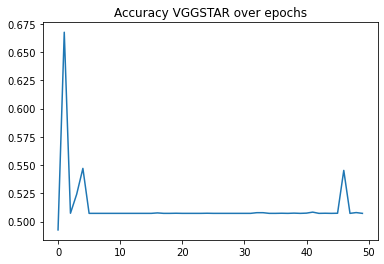

In [ ]:
if (DO=='TRAIN'):
  train(nets, loaders, optimizer, criterion, epochs=50, dev=dev,save_param=True)
else:
  state_dicts = torch.load('model.pth')
  model1.load_state_dict(state_dicts['vgg_a']) #questi state_dict vengono dalla funzione di training
  model2.load_state_dict(state_dicts['vgg_b'])
  model3.load_state_dict(state_dicts['vgg_star'])
  classifier.load_state_dict(state_dicts['classifier'])

  test(model1,classifier,test_loader_all)
  test(model2, classifier, test_loader_all)
  test(model3, classifier, test_loader_all)

  summed_state_dict = OrderedDict()

  for key in state_dicts['vgg_star']:
    if key.find('conv') >=0:
      print(key)
      summed_state_dict[key] = combo_fn(state_dicts['vgg_a'][key],state_dicts['vgg_b'][key])
    else:
      summed_state_dict[key] = state_dicts['vgg_star'][key]

  model3.load_state_dict(summed_state_dict)
  test(model3, classifier, test_loader_all)

In [ ]:
!pip install --upgrade progressbar2

  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0
